## Cloning the repo

In [1]:
!git clone https://github.com/Dineswar11/dretino

Cloning into 'dretino'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 100 (delta 38), reused 87 (delta 27), pack-reused 0
Receiving objects: 100% (100/100), 9.25 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (38/38), done.


### **Installing the package**

In [2]:
import os
os.chdir('./dretino')
!pwd
!pip install .

/kaggle/working/dretino
Processing /kaggle/working/dretino
  Preparing metadata (setup.py) ... done
  Created wheel for dretino: filename=dretino-0.1.0-py3-none-any.whl size=18074 sha256=7a93d296b929b6fb36229c1f781462837db48fdd5b0b3874df030d673d8ce184
  Stored in directory: /tmp/pip-ephem-wheel-cache-0s74bsbw/wheels/d8/80/6d/32bd321dd4e31311e6a8f44bd6e4b6670ce30f7880568095f3
Successfully built dretino


In [3]:
!pip install -qU pytorch-lightning wandb timm
!pip install -qU torchmetrics --upgrade

## Importing Libraries

In [4]:
import wandb
import pandas as pd

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2


from dretino.dataloader.build_features import DRDataModule
from dretino.models.predict_model import test
from dretino.models.train_model import Model, train
from dretino.visualization.visualize import show_images, cal_mean, plot_metrics

## WandB Login

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB = user_secrets.get_secret("wandb")

wandb.login(key=WANDB)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Reading the Dataset

In [6]:
os.chdir('/kaggle/working')

PATH = '../input/indian-retina-classification/B._20Disease_20Grading/B. Disease Grading/'
IMG_PATH = '../input/indian-retina-classification/B._20Disease_20Grading/B. Disease Grading/1. Original Images/'
dfx = pd.read_csv(PATH+'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',usecols = ['Image name','Retinopathy grade'])
df_test = pd.read_csv(PATH+'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',usecols = ['Image name','Retinopathy grade'])
df_train, df_valid = train_test_split(
    dfx, 
    test_size=0.2, 
    random_state=42, 
    stratify=dfx['Retinopathy grade'].values
)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

df_train.head()

,Image name,Retinopathy grade
0,IDRiD_402,1
1,IDRiD_398,2
2,IDRiD_381,0
3,IDRiD_067,4
4,IDRiD_123,2


## Creating a DataModule

In [7]:
train_transforms = A.Compose(
    [
        A.Resize(width=250, height=250),
        A.RandomCrop(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Blur(p=0.15),
        A.CLAHE(p=0.15),
        A.ColorJitter(p=0.15),
        A.Affine(shear=30, rotate=0, p=0.1),
        A.Normalize(
            mean=(0.5237, 0.2542, 0.0853),
            std=(0.2649, 0.1497, 0.0876),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(
            mean=(0.5237, 0.2542, 0.0853),
            std=(0.2649, 0.1497, 0.0876),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(
            mean=(0.5237, 0.2542, 0.0853),
            std=(0.2649, 0.1497, 0.0876),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

dm = DRDataModule(df_train, df_valid, df_test,
                  train_path=IMG_PATH + 'images_resized',
                  valid_path=IMG_PATH + 'images_resized',
                  test_path=IMG_PATH + 'test_images_resized',
                  train_transforms=train_transforms,
                  val_transforms=val_transforms,
                  test_transforms=test_transforms,
                  num_workers=2,
                  batch_size=16)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:122: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
100%|██████████| 330/330 [01:03<00:00,  5.20it/s]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:115: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."


#### Train Images

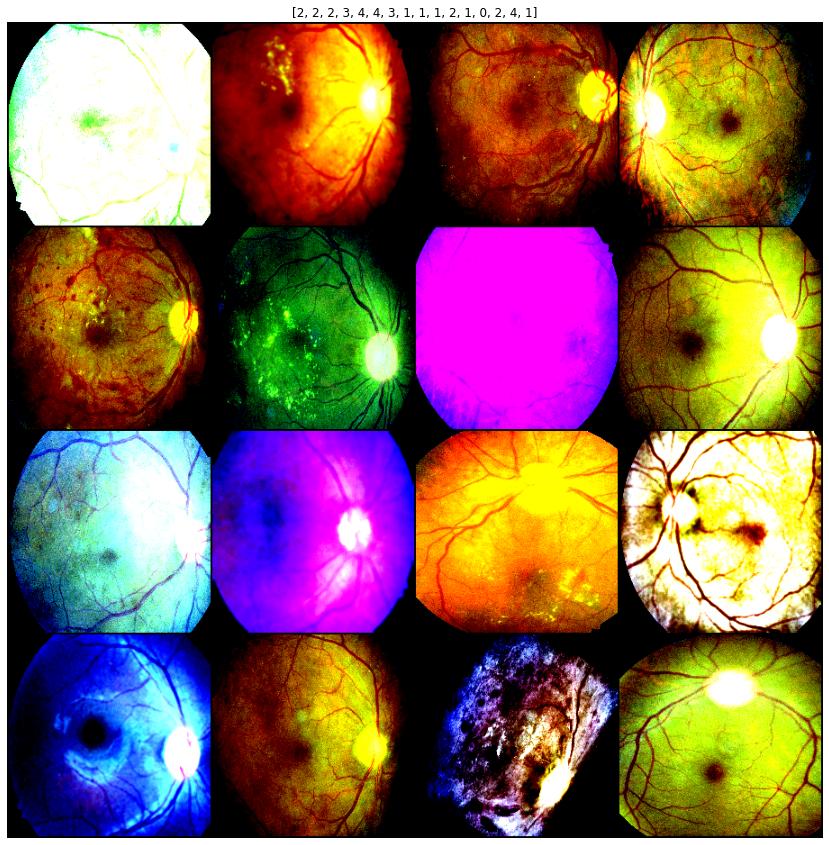

In [8]:
show_images(dm.train_dataloader())

#### Validation Images

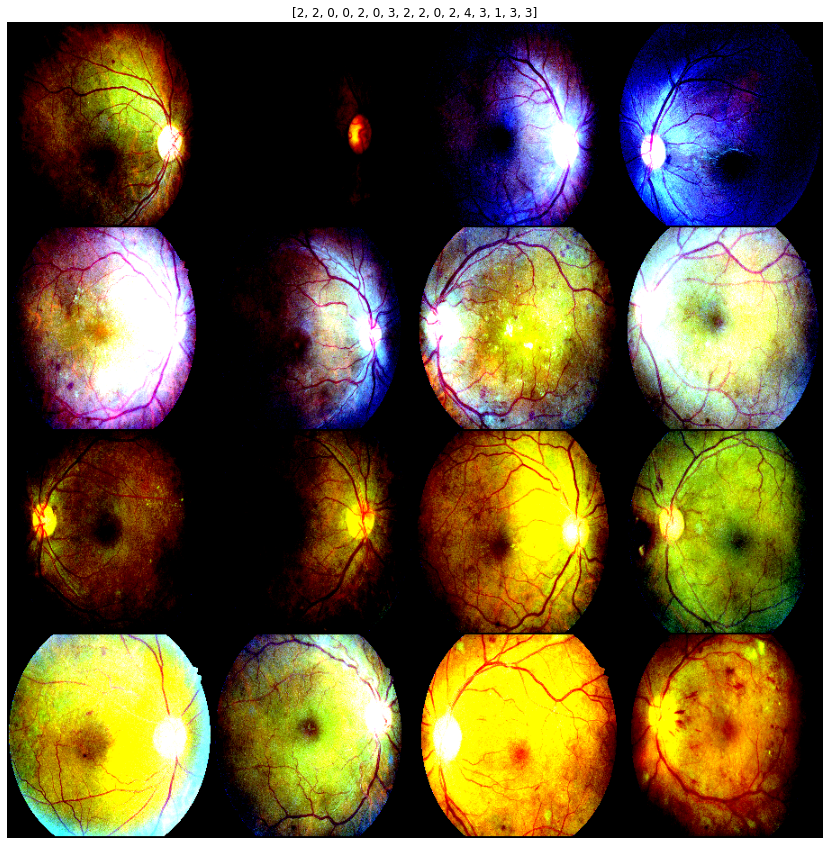

In [9]:
show_images(dm.val_dataloader())

#### Test Images

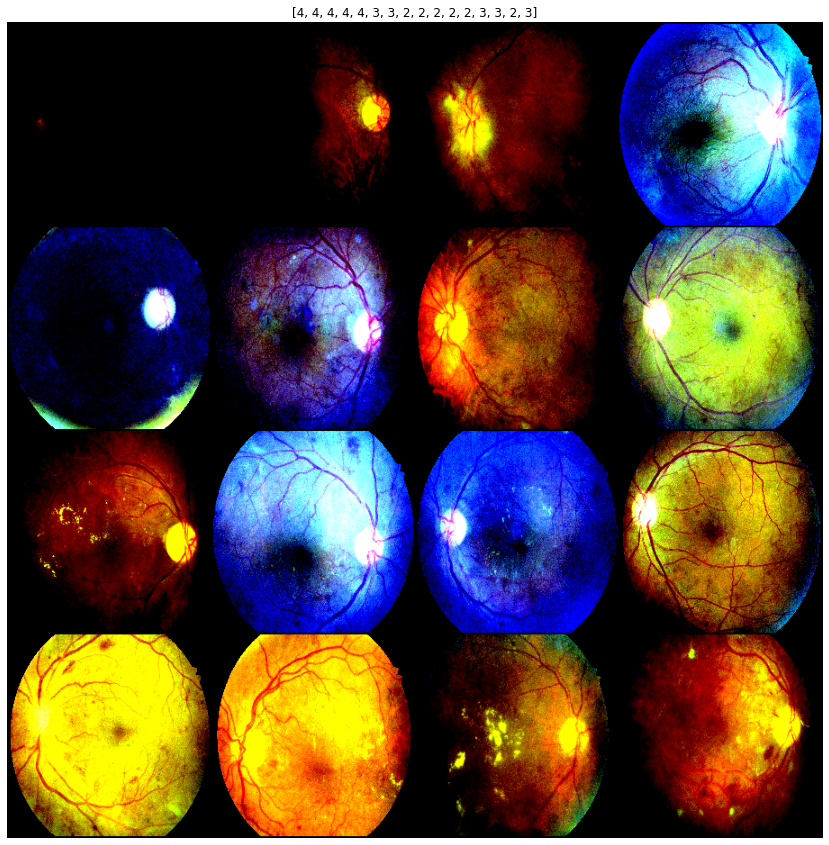

In [10]:
show_images(dm.test_dataloader())

## Training on resnet50d **No Additional Layers with Aug**

***Coral loss 200 epochs***

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /kaggle/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


2022-03-02215116.005051_coral_512_2_0.2_0.0003


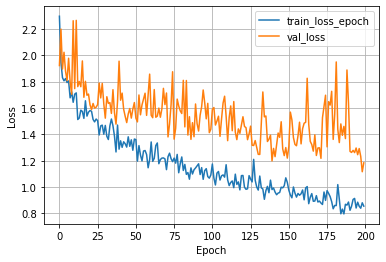

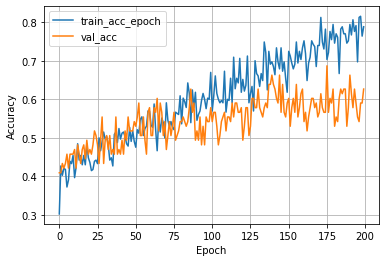

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_F1_score': 0.35922330617904663,
 'test_accuracy': 0.35922330617904663,
 'test_loss': 2.2116336822509766}
--------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_F1_score,▁
test_accuracy,▁
test_loss,▁
train_acc_epoch,▂▁▂▂▂▂▃▂▃▃▄▃▄▄▄▄▅▅▄▅▅▅▅▆▅▄▆▇▆▆▆▇▆▇▇█▆███
train_acc_step,▁▃▃▂▅▁▂▂▃▄▂▃▁▂▆▅▄▆▃▆▆▅▃▅▅▆▅▄▆▆▃▆▆█▇▆▆▇▆▅
train_kappa_epoch,▂▁▂▂▂▂▃▂▃▃▃▃▃▄▄▄▅▅▄▅▅▅▅▅▅▄▆▇▆▆▆▇▆▇▇█▆███
train_kappa_step,▁▃▃▂▄▁▂▂▃▄▂▃▁▂▆▄▄▅▃▆▅▅▃▄▄▆▄▄▆▅▃▆▅█▇▆▆▇▆▅
train_loss_epoch,█▇▇▆▆▅▄▅▄▄▃▄▃▃▃▄▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁
train_loss_step,█▇▆█▃▇█▇▅▄▅▄▆▅▄▂▃▂▂▂▁▂▄▂▂▂▂▂▂▂▄▂▃▁▂▂▂▁▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [15]:
args = dict(
    model_name='resnet50d',
    num_neurons=512,
    num_layers=2,
    dropout=0.2,
    lr=3e-4,
    loss='coral',
    epochs=200,
    gpus=1,
    project='DRD',
    additional_layers=False
)

wab = True
fast_dev_run = False
overfit_batches = False



file_name, trainer = train(Model, dm,
                           wab=wab,
                           fast_dev_run=fast_dev_run,
                           overfit_batches=overfit_batches,
                           **args)

print(file_name)

if not fast_dev_run:
    plot_metrics('../reports/csv_logs/' + file_name)

    test(Model, dm,
         file_name,
         trainer,
         wab=wab,
         fast_dev_run=fast_dev_run,
         overfit_batches=overfit_batches)